In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ot
from utils.image import Image
from utils.Visualizations import *
from utils.utils import *
import itertools
import glob
from scipy.stats import normaltest, gaussian_kde, probplot
from scipy.optimize import curve_fit
import time
from tqdm import tqdm

In [3]:
dotmark_pictures_path = "..\\DOTmark_1.0\\Pictures\\"
full_path = os.path.join(os.getcwd(), dotmark_pictures_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
noise_values = np.logspace(start = -8, stop = 2, num = 100)
categories_pattern = os.path.join(dotmark_pictures_path, "*")
category_dirs = [path for path in glob.glob(categories_pattern) if os.path.isdir(path)]
category_names = [os.path.basename(category) for category in category_dirs if os.path.isdir(category)]

In [67]:
num_exp = 100  # Number of experiments to run for each image pair and noise level
results_B_x = pd.DataFrame(columns=[
    'Category', 'Image_Pair', 'Alpha_1_Mean', 'Alpha_1_Std', 'Alpha_2_Mean', 'Alpha_2_Std', 'B_x_Mean', 'B_x_Std', 'Noise', 'B_x_tilde_Mean', 'B_x_tilde_Std'])

for category in category_names:
    print(f'Category: {category}')
    for noise in noise_values:
        for pair in list(itertools.combinations(image_numbers, 2)):
            alpha_1s = np.zeros(num_exp)
            alpha_2s = np.zeros(num_exp)
            B_xs = np.zeros((num_exp, resolution, resolution))  # Store B_x for each experiment
            B_xs_tilde = np.zeros((num_exp, resolution, resolution))  # Store B_x_tilde for each experiment
            image1 = Image(resolution, category_names[0], pair[0], full_path)
            image2 = Image(resolution, category_names[0], pair[1], full_path)

            for i in range(num_exp):
                results = Image.process_images(image1, image2, noise)
                alpha_1 = (1 / image1.image_post_noised.sum()) - 1
                alpha_2 = (1 / image2.image_post_noised.sum()) - 1
                B_x = image1.image_post_noised * alpha_1 - image2.image_post_noised * alpha_2
                alpha_1s[i] = alpha_1
                alpha_2s[i] = alpha_2
                B_xs[i, :, :] = B_x  # Store each B_x result
                B_xs_tilde[i, :, :] = B_x - alpha_1 * image1.image + alpha_2 * image2.image

            # Calculate the means and standard deviations
            alpha_1_mean, alpha_1_std = alpha_1s.mean(), alpha_1s.std()
            alpha_2_mean, alpha_2_std = alpha_2s.mean(), alpha_2s.std()
            B_x_mean, B_x_std = B_xs.mean(axis=0), B_xs.std(axis=0)
            B_x_tilde_mean, B_x_tilde_std = B_xs_tilde.mean(axis=0), B_xs_tilde.std(axis=0)

            # Store results in the DataFrame
            results_B_x = results_B_x._append({
                'Category': category,
                'Noise': noise,
                'Image_Pair': pair,
                'Alpha_1_Mean': alpha_1_mean,
                'Alpha_1_Std': alpha_1_std,
                'Alpha_2_Mean': alpha_2_mean,
                'Alpha_2_Std': alpha_2_std,
                'B_x_Mean': B_x_mean.mean(),  # Storing the overall mean of the matrix
                'B_x_Std': B_x_std.mean(),  # Storing the overall mean of the std of the matrix
                'B_x_tilde_Mean': B_x_tilde_mean.mean(),
                'B_x_tilde_Std': B_x_tilde_std.mean()
            }, ignore_index=True)

Category: CauchyDensity


C:\Users\eriki\AppData\Local\Temp\ipykernel_25592\2449704004.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_B_x = results_B_x._append({


Category: ClassicImages
Category: GRFmoderate
Category: GRFrough
Category: GRFsmooth
Category: LogGRF
Category: LogitGRF
Category: MicroscopyImages
Category: Shapes
Category: WhiteNoise


In [68]:
results_B_x.head()

,Category,Image_Pair,Alpha_1_Mean,Alpha_1_Std,Alpha_2_Mean,Alpha_2_Std,B_x_Mean,B_x_Std,Noise,B_x_tilde_Mean,B_x_tilde_Std
0,CauchyDensity,"(01, 02)",-0.000002,2.897189e-07,-0.000002,3.048014e-07,5.591610e-12,4.615218e-10,1.000000e-08,3.178479e-17,2.917818e-14
1,CauchyDensity,"(01, 03)",-0.000002,2.845515e-07,-0.000002,3.376344e-07,1.039816e-11,5.179197e-10,1.000000e-08,6.731007e-17,2.420835e-14
2,CauchyDensity,"(01, 04)",-0.000002,2.703146e-07,-0.000002,3.118447e-07,-3.140409e-11,4.506776e-10,1.000000e-08,-8.095253e-17,2.366129e-14
3,CauchyDensity,"(01, 05)",-0.000002,2.549950e-07,-0.000002,3.218234e-07,-4.122196e-11,5.340830e-10,1.000000e-08,-9.551286e-17,2.300117e-14
4,CauchyDensity,"(01, 06)",-0.000002,3.132720e-07,-0.000002,3.694138e-07,8.532500e-11,6.127858e-10,1.000000e-08,3.190075e-16,2.384014e-14


In [69]:
results_B_x = results_B_x.drop(['Category', 'Image_Pair'], axis=1)
results_B_x['log_Noise'] = np.log10(results_B_x['Noise'])

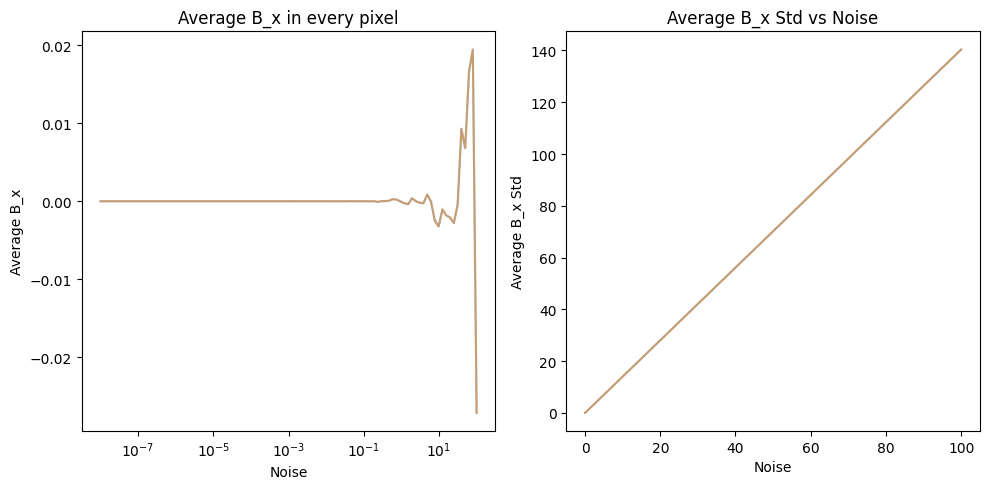

In [76]:
grouped_results = results_B_x.groupby('Noise').mean().reset_index()

# Plot B_x_mean vs Noise
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(grouped_results['Noise'], grouped_results['B_x_Mean'], label='B_x_Mean', alpha=0.5)
plt.plot(grouped_results['Noise'], grouped_results['B_x_tilde_Mean'], label='B_x_tilde_Mean', alpha=0.5)
plt.xscale('log')
plt.xlabel('Noise')
plt.ylabel('Average B_x')
plt.title('Average B_x in every pixel')

# Plot B_x_std vs Noise
plt.subplot(1, 2, 2)
plt.plot(grouped_results['Noise'], grouped_results['B_x_Std'], label='B_x_Std', alpha=0.5)
plt.plot(grouped_results['Noise'], grouped_results['B_x_tilde_Std'], label='B_x_tilde_Std', alpha=0.5)
# plt.xscale('log')
plt.xlabel('Noise')
plt.ylabel('Average B_x Std')
plt.title('Average B_x Std vs Noise')

plt.tight_layout()
plt.show()

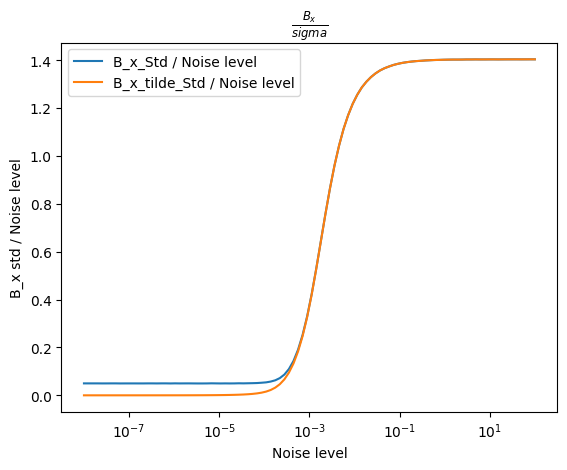

In [86]:
plt.plot(grouped_results['Noise'], grouped_results['B_x_Std'] / grouped_results['Noise'], label='B_x_Std / Noise level')
plt.plot(grouped_results['Noise'], grouped_results['B_x_tilde_Std'] / grouped_results['Noise'], label='B_x_tilde_Std / Noise level')
plt.xlabel('Noise level')
plt.xscale('log')
plt.ylabel('B_x std / Noise level')
plt.title(r"$\frac{B_x}{sigma}$")
plt.legend()
plt.show()

In [84]:
print('The minimum value of B_x_Mean is:', grouped_results['B_x_Std'].min())
print('The minimum value of B_x_Std / Noise is:', (grouped_results['B_x_Std'] / grouped_results['Noise']).min())
print('The maximum value of B_x_Std / Noise is:', (grouped_results['B_x_Std'] / grouped_results['Noise']).max())
print('The minimum value of B_x_tilde_Mean is:', grouped_results['B_x_tilde_Std'].min())
print('The minimum value of B_x_tilde_Std / Noise is:', (grouped_results['B_x_tilde_Std'] / grouped_results['Noise']).min())
print('The maximum value of B_x_tilde_Std / Noise is:', (grouped_results['B_x_tilde_Std'] / grouped_results['Noise']).max())

The minimum value of B_x_Mean is: 4.98744710488607e-10
The minimum value of B_x_Std / Noise is: 0.04958606763385275
The maximum value of B_x_Std / Noise is: 1.4037187119020587
The minimum value of B_x_tilde_Mean is: 9.02660411142298e-15
The minimum value of B_x_tilde_Std / Noise is: 9.02660411142298e-07
The maximum value of B_x_tilde_Std / Noise is: 1.403718711901727


In [79]:
# Logistic function for Alpha Mean
def logistic(x, A, B, C):
    return A / (1 + np.exp(B * (x - C)))

# Gaussian function for Alpha Std
def gaussian(x, D, E, F):
    return D * np.exp(-((x - E) ** 2) / (2 * F ** 2))

In [95]:
params_erik = [-1, -np.pi, -np.e]

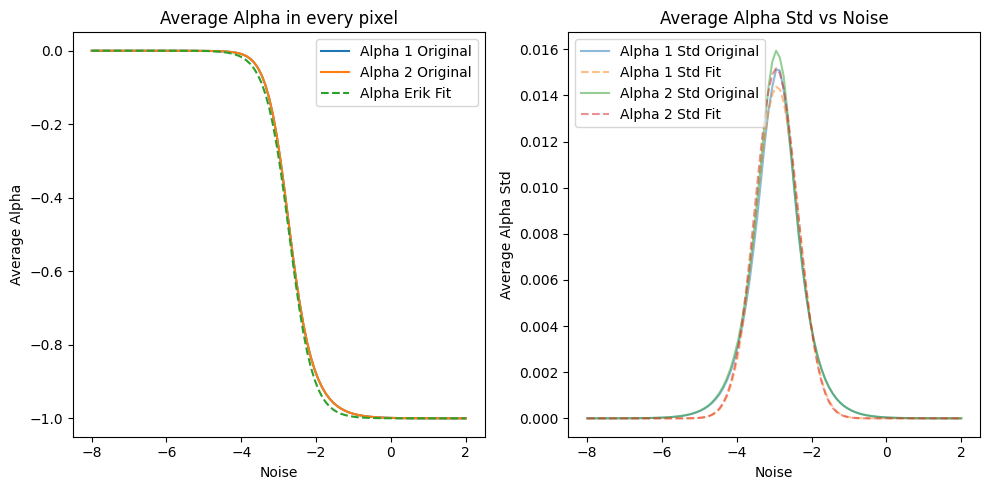

In [96]:
# Fit the models for Alpha 1 Mean
params_mean_1, _ = curve_fit(logistic, grouped_results['log_Noise'], grouped_results['Alpha_1_Mean'], p0=[1, 1, 0])
params_mean_2, _ = curve_fit(logistic, grouped_results['log_Noise'], grouped_results['Alpha_2_Mean'], p0=[1, 1, 0])

# Fit the models for Alpha 1 Std
params_std_1, _ = curve_fit(gaussian, grouped_results['log_Noise'], grouped_results['Alpha_1_Std'], p0=[0.01, 0, 1])
params_std_2, _ = curve_fit(gaussian, grouped_results['log_Noise'], grouped_results['Alpha_2_Std'], p0=[0.01, 0, 1])

# Generate fitted values
fitted_mean_1 = logistic(grouped_results['log_Noise'], *params_mean_1)
fitted_mean_2 = logistic(grouped_results['log_Noise'], *params_mean_2)
fitted_mean_erik = logistic(grouped_results['log_Noise'], *params_erik)
fitted_std_1 = gaussian(grouped_results['log_Noise'], *params_std_1)
fitted_std_2 = gaussian(grouped_results['log_Noise'], *params_std_2)

# Plot the alphas:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_1_Mean'], label='Alpha 1 Original')
# plt.plot(grouped_results['log_Noise'], fitted_mean_1, label='Alpha 1 Fit', linestyle='--')
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_2_Mean'], label='Alpha 2 Original')
# plt.plot(grouped_results['log_Noise'], fitted_mean_2, label='Alpha 2 Fit', linestyle='--')
plt.plot(grouped_results['log_Noise'], fitted_mean_erik, label='Alpha Erik Fit', linestyle='--')
plt.xlabel('Noise')
plt.ylabel('Average Alpha')
plt.title('Average Alpha in every pixel')
plt.legend()

# Plot Alpha Std vs Noise
plt.subplot(1, 2, 2)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_1_Std'], label='Alpha 1 Std Original', alpha=0.5)
plt.plot(grouped_results['log_Noise'], fitted_std_1, label='Alpha 1 Std Fit', linestyle='--', alpha=0.5)
plt.plot(grouped_results['log_Noise'], grouped_results['Alpha_2_Std'], label='Alpha 2 Std Original', alpha=0.5)
plt.plot(grouped_results['log_Noise'], fitted_std_2, label='Alpha 2 Std Fit', linestyle='--', alpha=0.5)
plt.xlabel('Noise')
plt.ylabel('Average Alpha Std')
plt.title('Average Alpha Std vs Noise')
plt.legend()

plt.tight_layout()
plt.show()

In [88]:
# Print the parameters of the mean
print('Alpha 1 Mean:')
print('A:', params_mean_1[0])
print('B:', params_mean_1[1])
print('C:', params_mean_1[2])
print('Alpha 2 Mean:')
print('A:', params_mean_2[0])
print('B:', params_mean_2[1])
print('C:', params_mean_2[2])

Alpha 1 Mean:
A: -0.9956316952734464
B: -3.164822928645536
C: -2.6797309404428225
Alpha 2 Mean:
A: -0.9956294628842174
B: -3.1651133260849296
C: -2.679686646450114


B_x Mean: -9.217186098094608e-09
B_x Std: 5.947475585920761e-06
B_x_tilde Mean: 9.345455111591051e-10
B_x_tilde Std: 1.7137717423347125e-06


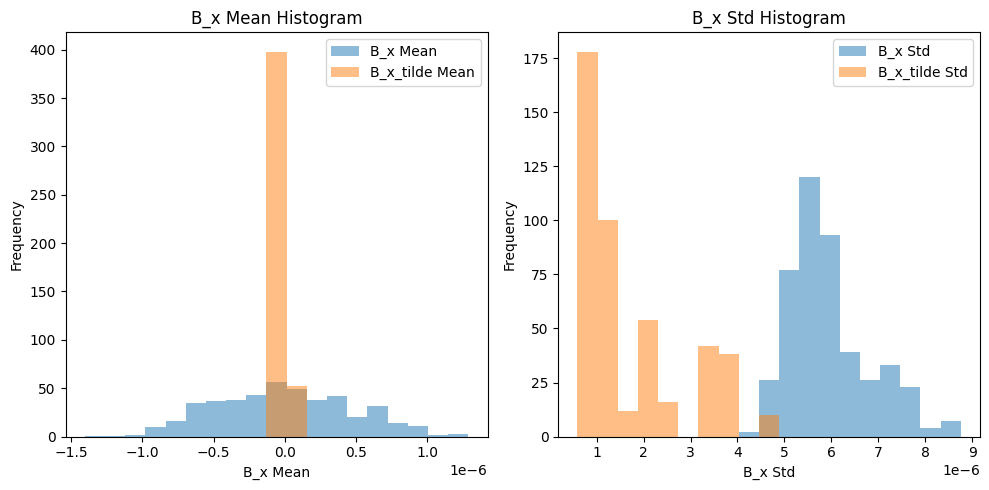

In [82]:
noise_index = 40
noise = noise_values[noise_index]

# Look into the values for the defined value of noise:
results_B_x_noise = results_B_x[results_B_x['Noise'] == noise]
results_B_x_noise = results_B_x_noise.drop('Noise', axis=1)

# Print the mean and std of the B_x and B_x_tilde
print('B_x Mean:', results_B_x_noise['B_x_Mean'].mean())
print('B_x Std:', results_B_x_noise['B_x_Std'].mean())
print('B_x_tilde Mean:', results_B_x_noise['B_x_tilde_Mean'].mean())
print('B_x_tilde Std:', results_B_x_noise['B_x_tilde_Std'].mean())

# Plot the B_x mean and std for the defined noise level
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
min_bin = min(results_B_x_noise['B_x_Mean'].min(), results_B_x_noise['B_x_tilde_Mean'].min())
max_bin = max(results_B_x_noise['B_x_Mean'].max(), results_B_x_noise['B_x_tilde_Mean'].max())
bins = np.linspace(min_bin, max_bin, 20)
plt.hist(results_B_x_noise['B_x_Mean'], bins, alpha=0.5, label='B_x Mean')
plt.hist(results_B_x_noise['B_x_tilde_Mean'], bins, alpha=0.5, label='B_x_tilde Mean')
plt.xlabel('B_x Mean')
plt.ylabel('Frequency')
plt.legend()
plt.title('B_x Mean Histogram')

plt.subplot(1, 2, 2)
min_bin = min(results_B_x_noise['B_x_Std'].min(), results_B_x_noise['B_x_tilde_Std'].min())
max_bin = max(results_B_x_noise['B_x_Std'].max(), results_B_x_noise['B_x_tilde_Std'].max())
bins = np.linspace(min_bin, max_bin, 20)
plt.hist(results_B_x_noise['B_x_Std'], bins, alpha=0.5, label='B_x Std')
plt.hist(results_B_x_noise['B_x_tilde_Std'], bins, alpha=0.5, label='B_x_tilde Std')
plt.xlabel('B_x Std')
plt.ylabel('Frequency')
plt.legend()
plt.title('B_x Std Histogram')

plt.tight_layout()
plt.show()